In [39]:
# 导入必要的库，用于数据加载和预处理
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image

# 定义一个自定义的Flickr30k数据集类
class Flickr30kDataset(torch.utils.data.Dataset):
    # 初始化函数，加载数据集、设置图像变换及每张图片的描述数量
    def __init__(self,transform=None):
        # 使用Hugging Face的Datasets库加载Flickr30k数据集，缓存到指定目录
        self.dataset = load_dataset("nlphuji/flickr30k", cache_dir="./huggingface_data")
        # 定义图像预处理变换，包括调整尺寸为224x224和转换为Tensor
        if transform==None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),  # 尺寸调整
                transforms.ToTensor(),  # 转换为Tensor
            ])
        else:
            self.transform=transform
        # 每张图片对应的描述数量
        self.cap_per_image = 2

    # 返回数据集中元素的数量
    def __len__(self):
        # 计算测试集的行数乘以每张图片的描述数量
        return self.dataset.num_rows["test"] * self.cap_per_image

    # 获取数据集中的指定索引元素，包括图像和对应描述
    def __getitem__(self, idx):
        # 计算原始图片的索引
        original_idx = idx // self.cap_per_image
        # 获取图片路径（注：此行代码未使用，但通常此处应获取图像路径）
        # image_path = self.dataset[idx]["image_path"]
        
        # 加载并预处理图片
        image = self.dataset["test"][original_idx]["image"].convert("RGB")
        image = self.transform(image)

        # 根据任务需求调整标签
        # 获取当前索引对应的图片描述
        caption = self.dataset["test"][original_idx]["caption"][idx % self.cap_per_image]

        # 返回图像和其对应的描述
        return {"image": image, "caption": caption}

# 创建自定义Flickr30k数据集实例
flickr30k_custom_dataset = Flickr30kDataset()
# Create the DataLoader
clip_dataloader = DataLoader(flickr30k_custom_dataset, batch_size=Config.batch_size, shuffle=True,num_workers=4)

In [2]:
flickr30k_custom_dataset.dataset['test'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.'],
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg'}

In [6]:
from dataclasses import dataclass


@dataclass
class Config:
    """
    Configuration class for the CLIP training script.
    """
    embed_dim: int = 512  # Embedding dimension
    transformer_embed_dim: int = 768  # Transformer embedding dimension
    max_len: int = 32  # Maximum text length
    text_model: str = "distilbert-base-multilingual-cased"  # Text model name
    epochs: int = 5  # Number of training epochs
    batch_size: int = 32 # Batch size
config=Config()

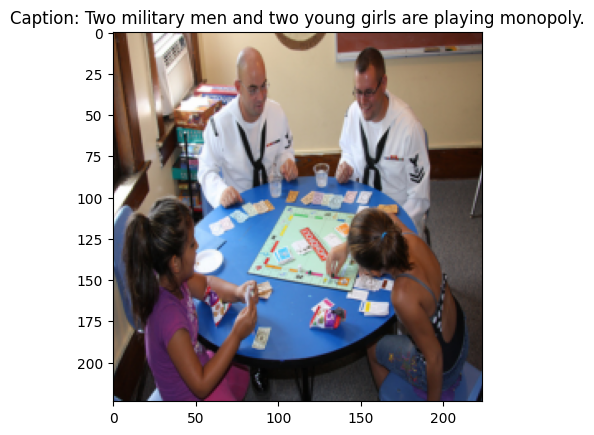

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Create an iterator from the dataloader
data_iter = iter(clip_dataloader)

# Get one batch
batch = next(data_iter)

image = batch["image"][0]  # Assuming batch size is greater than 0
caption = batch["caption"][0]

# Convert the image tensor to a NumPy array and permute dimensions
image_np = np.transpose(image.numpy(), (1, 2, 0))

# Display the image and caption
plt.imshow(image_np)
plt.title(f"Caption: {caption}")
plt.show()

In [8]:
import torch.nn.functional as F
device=torch.device('cuda:0')
def CLIP_loss(logits):
    n=logits.shape[1]## (n,n)
    label=torch.arange(n).to(device)
    
    loss_i=F.cross_entropy(logits.transpose(0,1),label,reduction='mean')
    loss_t=F.cross_entropy(logits,label,reduction='mean')
    
    loss=(loss_i+loss_t)/2
    return loss


def metrics(similarity):
    """
    similarity:余弦相似度
    """
    n=similarity.shape[0]
    y=torch.arange(n).to(similarity.device)
    img_to_text_match_id=similarity.argmax(dim=1)
    text_to_img_match_id=similarity.argmax(dim=0)
    
    img_acc=(img_to_text_match_id==y).float().mean()
    text_acc=(text_to_img_match_id==y).float().mean()
    return img_acc,text_acc

## CLIP实现
- image-Encoder 使用vit-b
- text-Encoder 使用distill-bert

In [73]:
from transformers import AutoModel,AutoTokenizer
from torchvision import models
from torch import nn

class Projection(nn.Module):
    def __init__(self,in_dim,out_dim,dropout_rate=0.2):
        super().__init__()
        self.fc1=nn.Linear(in_dim,out_dim)
        self.norm=nn.LayerNorm(in_dim)
    def forward(self,x):
        x=self.norm(x)
        x=self.fc1(x)
        return x

class VisionEncoder(nn.Module):
    def __init__(self,out_dim,model_type='vit'):
        super().__init__()
        if model_type=='vit':
            base=models.vit_b_32(pretrained=True)
            in_dim=base.heads[0].in_features
            base.heads=nn.Identity()
        else:
            base=models.resnet34(pretrained=True)
            in_dim=base.fc.in_features
            base.fc=nn.Identity()
        self.base=base
        self.proj=Projection(in_dim,out_dim)
        for p in self.base.parameters():
            p.requires_grad=False
    def forward(self,x):
        x=self.base(x)
        x=self.proj(x)
        return x
    
class TextEncoder(nn.Module):
    def __init__(self,out_dim):
        super().__init__()
        self.base=AutoModel.from_pretrained(config.text_model)
        self.proj=Projection(config.transformer_embed_dim,out_dim)
        for p in self.base.parameters():
            p.requires_grad=False
    def forward(self,x):
        x=self.base(x)[0]
        #print(x.shape)
        x=x[:,0,:]
        x=self.proj(x)
        return x
    
class Tokenizer():
    def __init__(self,tokenizer):
        self.tokenizer=tokenizer
    def __call__(self,x):
        return self.tokenizer(x,
                              max_length=config.max_len,
                              truncation=True,
                              padding=True,
                              return_tensors='pt'
                             )

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]

vision_encoder = VisionEncoder(Config.embed_dim).to(device)
caption_encoder = TextEncoder(Config.embed_dim).to(device)
tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model))

for captions in [true_text, wrong_text]:
    text = tokenizer(captions).to(device)

    # with torch.no_grad():
    image_features = vision_encoder(image)
    text_features = caption_encoder(text["input_ids"])

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 160MB/s]  


tensor(3.4647, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4666, device='cuda:0', grad_fn=<DivBackward0>)


In [74]:
class MyCLIP(nn.Module):
    def __init__(self,):
        super().__init__()
        self.Image_Encoder=VisionEncoder(config.embed_dim)
        self.Text_Encoder=TextEncoder(config.embed_dim)
        ## 直接优化控制 softmax 中 logits 范围的温度参数 t
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.tokenizer=Tokenizer(AutoTokenizer.from_pretrained(config.text_model,use_fast=True))
    def forward(self,images,texts):
        texts=self.tokenizer(texts)['input_ids'].to(images.device)
        image_features=self.Image_Encoder(images)
        text_features=self.Text_Encoder(texts)
        image_features=image_features/image_features.norm(dim=-1,keepdim=True)
        text_features=text_features/text_features.norm(dim=-1,keepdim=True)
        logit_scale = self.logit_scale.exp()
        similarity=logit_scale*image_features@text_features.T
        loss=CLIP_loss(similarity)
        acc1,acc2=metrics(similarity)
        return loss,acc1,acc2

In [75]:
model=MyCLIP().to(device)
lr=1e-3
optimizer=torch.optim.Adam([
    {'params':model.Image_Encoder.parameters()},
    {'params':model.Text_Encoder.parameters()}
],lr=lr)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:04<00:00, 86.8MB/s] 


In [76]:
from tqdm import tqdm
epochs=5
for epoch in range(epochs):
    model.train()
    with tqdm(total=len(clip_dataloader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch',mininterval=3) as pbar:
        for batch in clip_dataloader:
            images=batch['image'].to(device)
            texts=batch['caption']
            loss,acc1,acc2=model(images,texts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': f'{ loss.item():.4f}'})
            pbar.update(1)
    

Epoch 1/5:   0%|          | 0/1939 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_P

In [78]:
@torch.no_grad()
def test(n=100):
    total_loss=0
    total_acc1=0
    total_acc2=0
    model.eval()
    with tqdm(total=n, unit='batch',mininterval=3) as pbar:
        for i,batch in enumerate(clip_dataloader):
            if i==n:
                break
            images=batch['image'].to(device)
            texts=batch['caption']
            loss,acc1,acc2=model(images,texts)
            total_loss+=loss.item()
            total_acc1+=acc1.item()
            total_acc2+=acc2.item()
            #pbar.set_postfix({'loss': f'{ loss.item():.4f}'})
            pbar.update(1)
    print(f'loss:{total_loss/n} acc1:{total_acc1/n} acc2:{total_acc2/n}')
test()

  0%|          | 0/100 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(

loss:1.3952598637342453 acc1:0.5828125 acc2:0.565625


## 微调CLIP

In [7]:
!pip install git+https://github.com/openai/CLIP.git

In [79]:
import clip
model,process=clip.load('ViT-B/32',device=device)
model.eval()
flickr30k_custom_dataset = Flickr30kDataset(transform=process)
# Create the DataLoader

clip_dataloader = DataLoader(flickr30k_custom_dataset, batch_size=Config.batch_size, shuffle=True,num_workers=4)
data_iter = iter(clip_dataloader)
# Get one batch
batch = next(data_iter)
images=batch['image'].to(device)
texts=batch['caption']

texts=clip.tokenize(texts).to(device)
img_features=model.encode_image(images)
text_features=model.encode_text(texts)

img_features=img_features/img_features.norm(dim=1,keepdim=True)
text_features=text_features/text_features.norm(dim=1,keepdim=True)
similarity=model.logit_scale.exp()*img_features@text_features.T ## 点乘
loss=CLIP_loss(similarity)
print(loss)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

tensor(0.2063, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


In [81]:
@torch.no_grad()
def test(n=100):
    total_loss=0
    total_acc1=0
    total_acc2=0
    model.eval()
    with tqdm(total=n, unit='batch',mininterval=3) as pbar:
        for i,batch in enumerate(clip_dataloader):
            if i==n:
                break
            images=batch['image'].to(device)
            texts=clip.tokenize(batch['caption'],truncate=True).to(device)
            logits,_=model(images,texts)
            loss=CLIP_loss(logits)
            acc1,acc2=metrics(logits)
            total_loss+=loss.item()
            total_acc1+=acc1.item()
            total_acc2+=acc2.item()
            #pbar.set_postfix({'loss': f'{ loss.item():.4f}'})
            pbar.update(1)
    print(f'loss:{total_loss/n} acc1:{total_acc1/n} acc2:{total_acc2/n}')
test()

  0%|          | 0/100 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(

loss:0.17604782104492187 acc1:0.953125 acc2:0.938125


In [50]:
model,process=clip.load('ViT-B/32',device=device)
for x,y in model.named_parameters():
    print(x)

positional_embedding
text_projection
logit_scale
visual.class_embedding
visual.positional_embedding
visual.proj
visual.conv1.weight
visual.ln_pre.weight
visual.ln_pre.bias
visual.transformer.resblocks.0.attn.in_proj_weight
visual.transformer.resblocks.0.attn.in_proj_bias
visual.transformer.resblocks.0.attn.out_proj.weight
visual.transformer.resblocks.0.attn.out_proj.bias
visual.transformer.resblocks.0.ln_1.weight
visual.transformer.resblocks.0.ln_1.bias
visual.transformer.resblocks.0.mlp.c_fc.weight
visual.transformer.resblocks.0.mlp.c_fc.bias
visual.transformer.resblocks.0.mlp.c_proj.weight
visual.transformer.resblocks.0.mlp.c_proj.bias
visual.transformer.resblocks.0.ln_2.weight
visual.transformer.resblocks.0.ln_2.bias
visual.transformer.resblocks.1.attn.in_proj_weight
visual.transformer.resblocks.1.attn.in_proj_bias
visual.transformer.resblocks.1.attn.out_proj.weight
visual.transformer.resblocks.1.attn.out_proj.bias
visual.transformer.resblocks.1.ln_1.weight
visual.transformer.resblo

In [71]:
process

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7e96e3942830>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [82]:
## 转为fp32，否则会NAN
for param in model.parameters():  
    param.data = param.data.to(torch.float32) 
for param in model.parameters():
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.

In [83]:
## 仅训练投影层参数和温度系数t
def freeze_parameters(model,unfreeze_layers=None,show=False):
    if unfreeze_layers==None:
        unfreeze_layers=[name for name,param in model.named_parameters()]
    for name ,param in model.named_parameters():
        param.requires_grad = False
        for ele in unfreeze_layers:
            if ele in name:
                #print(name)
                param.requires_grad = True
                break
    #验证一下
    if show:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(name,param.size())
freeze_parameters(model,['visual.proj','text_projection','logit_scale'],True)

text_projection torch.Size([512, 512])
logit_scale torch.Size([])
visual.proj torch.Size([768, 512])


In [84]:
lr=1e-5
optimizer=torch.optim.Adam([
    {'params':model.parameters()}
],lr=lr)
from tqdm import tqdm
epochs=1
for epoch in range(epochs):
    model.train()
    with tqdm(total=len(clip_dataloader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch',mininterval=3) as pbar:
        for batch in clip_dataloader:
            images=batch['image'].to(device)
            texts=clip.tokenize(batch['caption'],truncate=True).to(device)
            logits,_=model(images,texts)
            loss=CLIP_loss(logits)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': f'{ loss.item():.4f}'})
            pbar.update(1)
    
        

Epoch 1/1:   0%|          | 0/1939 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_P

In [85]:
test()

  0%|          | 0/100 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(

loss:0.08113472392316907 acc1:0.9759375 acc2:0.96875
